In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

In [174]:
file_path = "B20000017_Seif_Assignment2.csv"
data = pd.read_csv(file_path)

In [175]:
data['rating'] = data['rating'].clip(lower=1, upper=5)

In [176]:
tnu = data['userId'].nunique()
tni = data['movieId'].nunique()
print(f"\nTotal Users (tnu): {tnu}")
print(f"Total Items (tni): {tni}\n")


Total Users (tnu): 5
Total Items (tni): 39



In [177]:
ratings_per_item = data.groupby('movieId')['rating'].count()
print("Ratings per item:")
print(ratings_per_item.head(), "\n...")

Ratings per item:
movieId
1     0
2     2
3     0
6     1
10    1
Name: rating, dtype: int64 
...


In [178]:
active_users = data['userId'].unique()[:3]  
missing_ratings = {active_users[0]: 2, active_users[1]: 3, active_users[2]: 5}

for user, missing_count in missing_ratings.items():
    user_data = data[data['userId'] == user]
    if len(user_data[user_data['rating'].notnull()]) >= missing_count:
        indices_to_nullify = user_data[user_data['rating'].notnull()].sample(n=missing_count, random_state=42).index
        data.loc[indices_to_nullify, 'rating'] = np.nan

print("Active users and their missing ratings:")
print(missing_ratings, "\n")

Active users and their missing ratings:
{1: 2, 2: 3, 3: 5} 



In [179]:
target_items = data['movieId'].unique()[:2]  
missing_percentages = {target_items[0]: 0.04, target_items[1]: 0.1}

for item, missing_percentage in missing_percentages.items():
    item_data = data[data['movieId'] == item]
    missing_count = int(len(item_data) * missing_percentage)
    if len(item_data[item_data['rating'].notnull()]) >= missing_count:
        indices_to_nullify = item_data[item_data['rating'].notnull()].sample(n=missing_count, random_state=42).index
        data.loc[indices_to_nullify, 'rating'] = np.nan

print("Target items and their missing ratings percentages:")
print(missing_percentages, "\n")

Target items and their missing ratings percentages:
{2: 0.04, 29: 0.1} 



In [180]:
common_users_data = []

for user in active_users:
    user_items = set(data[data['userId'] == user]['movieId'].dropna())
    for other_user in data['userId'].unique():
        if other_user != user:
            other_user_items = set(data[data['userId'] == other_user]['movieId'].dropna())
            common_items = user_items & other_user_items
            if common_items:
                common_users_data.append((user, other_user, len(common_items)))


Common users and co-rated items:
   OtherUser  No_coRated_items
3          5                 4
1          3                 3
2          4                 3
7          5                 3
8          1                 3 
...


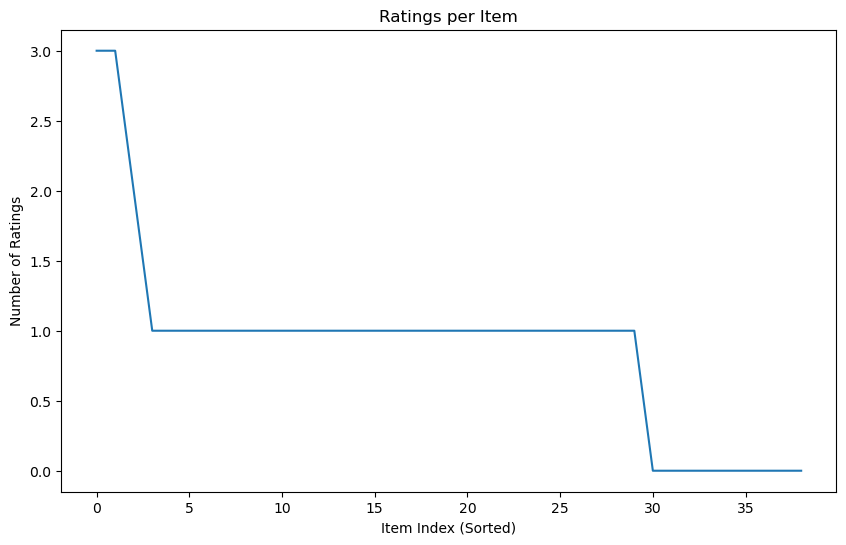

In [181]:
common_users_df = pd.DataFrame(common_users_data, columns=['ActiveUser', 'OtherUser', 'No_coRated_items'])
common_users_array = common_users_df.sort_values('No_coRated_items', ascending=False)[['OtherUser', 'No_coRated_items']]
print("\nCommon users and co-rated items:")
print(common_users_array.head(), "\n...")


ratings_per_item_sorted = ratings_per_item.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_item_sorted.values)
plt.xlabel('Item Index (Sorted)')
plt.ylabel('Number of Ratings')
plt.title('Ratings per Item')
plt.show()

In [182]:
thresholds = {}

for user in active_users:
    user_items = set(data[data['userId'] == user]['movieId'].dropna())
    total_items = len(user_items)
    required_items = int(total_items * 0.3)

    co_rated_users = []
    for other_user in data['userId'].unique():
        if other_user != user:
            other_user_items = set(data[data['userId'] == other_user]['movieId'].dropna())
            common_items = user_items & other_user_items
            if len(common_items) >= required_items:
                co_rated_users.append(other_user)

    thresholds[user] = len(co_rated_users)

print("Thresholds for active users (30% co-rated items):")
print(thresholds, "\n")

Thresholds for active users (30% co-rated items):
{1: 4, 2: 1, 3: 3} 



In [183]:
user_item_matrix = data.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean').fillna(0)
cosine_sim = cosine_similarity(user_item_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

In [184]:
closest_users = {}

for user in active_users:
    user_similarities = cosine_sim_df.loc[user].sort_values(ascending=False)
    top_20_percent = int(len(user_similarities) * 0.2)
    closest_users[user] = user_similarities.index[1:top_20_percent+1]  # Exclude the user itself

print("Top 20% closest users (cosine similarity):")
for user, neighbors in closest_users.items():
    print(f"User {user}: {list(neighbors)}")

Top 20% closest users (cosine similarity):
User 1: [5]
User 2: [1]
User 3: [1]


In [185]:
def predict_rating(active_user, item_id, neighbors):
    neighbor_ratings = user_item_matrix.loc[neighbors, item_id]
    similarity_scores = cosine_sim_df.loc[active_user, neighbors]
    numerator = (neighbor_ratings * similarity_scores).sum()
    denominator = similarity_scores.sum()
    return numerator / denominator if denominator != 0 else 0

predictions = {}

for user in active_users:
    unseen_items = user_item_matrix.loc[user][user_item_matrix.loc[user] == 0].index
    predictions[user] = {item: predict_rating(user, item, closest_users[user]) for item in unseen_items}

print("Predictions for unseen items (cosine similarity):")
for user, items in predictions.items():
    print(f"User {user}: {items}")

Predictions for unseen items (cosine similarity):
User 1: {6: 0.0, 10: 0.0, 11: 5.0, 17: 3.0, 19: 0.0, 24: 0.0, 32: 5.0, 60: 3.0, 110: 4.0, 123: 0.0, 124: 2.0, 129: 0.0, 140: 2.0, 141: 5.0, 156: 0.0, 166: 0.0, 167: 0.0, 168: 0.0, 169: 0.0, 170: 0.0, 175: 0.0, 180: 0.0, 196: 0.0}
User 2: {2: 0, 6: 0, 10: 0, 11: 0, 17: 0, 19: 0, 24: 0, 32: 0, 50: 0, 60: 0, 110: 0, 112: 0, 123: 0, 124: 0, 129: 0, 140: 0, 141: 0, 156: 0, 167: 0, 168: 0, 170: 0, 175: 0, 196: 0}
User 3: {2: 0, 6: 0, 10: 0, 11: 0, 17: 0, 19: 0, 32: 0, 50: 0, 60: 0, 110: 0, 112: 0, 124: 0, 129: 0, 140: 0, 141: 0, 156: 0, 166: 0, 167: 0, 168: 0, 169: 0, 170: 0, 180: 0}


In [186]:
def compute_discount_factor(active_user, beta):
    return 1 / (1 + np.exp(-beta))

discounted_similarities = {}

for user in active_users:
    beta = thresholds[user]
    discount_factor = compute_discount_factor(user, beta)
    discounted_similarities[user] = cosine_sim_df.loc[user] * discount_factor

In [187]:
closest_users_discounted = {}

for user in active_users:
    user_similarities = discounted_similarities[user].sort_values(ascending=False)
    top_20_percent = int(len(user_similarities) * 0.2)
    closest_users_discounted[user] = user_similarities.index[1:top_20_percent+1]

print("\nTop 20% closest users (discounted similarity):")
for user, neighbors in closest_users_discounted.items():
    print(f"User {user}: {list(neighbors)}")


Top 20% closest users (discounted similarity):
User 1: [5]
User 2: [1]
User 3: [1]


In [188]:
predictions_discounted = {}

for user in active_users:
    unseen_items = user_item_matrix.loc[user][user_item_matrix.loc[user] == 0].index
    predictions_discounted[user] = {item: predict_rating(user, item, closest_users_discounted[user]) for item in unseen_items}

print("\nPredictions for unseen items (discounted similarity):")
for user, items in predictions_discounted.items():
    print(f"User {user}: {items}")


Predictions for unseen items (discounted similarity):
User 1: {6: 0.0, 10: 0.0, 11: 5.0, 17: 3.0, 19: 0.0, 24: 0.0, 32: 5.0, 60: 3.0, 110: 4.0, 123: 0.0, 124: 2.0, 129: 0.0, 140: 2.0, 141: 5.0, 156: 0.0, 166: 0.0, 167: 0.0, 168: 0.0, 169: 0.0, 170: 0.0, 175: 0.0, 180: 0.0, 196: 0.0}
User 2: {2: 0, 6: 0, 10: 0, 11: 0, 17: 0, 19: 0, 24: 0, 32: 0, 50: 0, 60: 0, 110: 0, 112: 0, 123: 0, 124: 0, 129: 0, 140: 0, 141: 0, 156: 0, 167: 0, 168: 0, 170: 0, 175: 0, 196: 0}
User 3: {2: 0, 6: 0, 10: 0, 11: 0, 17: 0, 19: 0, 32: 0, 50: 0, 60: 0, 110: 0, 112: 0, 124: 0, 129: 0, 140: 0, 141: 0, 156: 0, 166: 0, 167: 0, 168: 0, 169: 0, 170: 0, 180: 0}


In [189]:
results = {
    "Closest Users": closest_users,
    "Predictions": predictions,
    "Discounted Closest Users": closest_users_discounted,
    "Discounted Predictions": predictions_discounted
          }


In [190]:
print("\nComparison of Results:")
for user in active_users:
    print(f"User {user}:")
    print(f"  Closest Users (cosine similarity): {list(closest_users[user])}")
    print(f"  Closest Users (discounted similarity): {list(closest_users_discounted[user])}")
    print(f"  Predictions (cosine similarity): {predictions[user]}")
    print(f"  Predictions (discounted similarity): {predictions_discounted[user]}\n")


Comparison of Results:
User 1:
  Closest Users (cosine similarity): [5]
  Closest Users (discounted similarity): [5]
  Predictions (cosine similarity): {6: 0.0, 10: 0.0, 11: 5.0, 17: 3.0, 19: 0.0, 24: 0.0, 32: 5.0, 60: 3.0, 110: 4.0, 123: 0.0, 124: 2.0, 129: 0.0, 140: 2.0, 141: 5.0, 156: 0.0, 166: 0.0, 167: 0.0, 168: 0.0, 169: 0.0, 170: 0.0, 175: 0.0, 180: 0.0, 196: 0.0}
  Predictions (discounted similarity): {6: 0.0, 10: 0.0, 11: 5.0, 17: 3.0, 19: 0.0, 24: 0.0, 32: 5.0, 60: 3.0, 110: 4.0, 123: 0.0, 124: 2.0, 129: 0.0, 140: 2.0, 141: 5.0, 156: 0.0, 166: 0.0, 167: 0.0, 168: 0.0, 169: 0.0, 170: 0.0, 175: 0.0, 180: 0.0, 196: 0.0}

User 2:
  Closest Users (cosine similarity): [1]
  Closest Users (discounted similarity): [1]
  Predictions (cosine similarity): {2: 0, 6: 0, 10: 0, 11: 0, 17: 0, 19: 0, 24: 0, 32: 0, 50: 0, 60: 0, 110: 0, 112: 0, 123: 0, 124: 0, 129: 0, 140: 0, 141: 0, 156: 0, 167: 0, 168: 0, 170: 0, 175: 0, 196: 0}
  Predictions (discounted similarity): {2: 0, 6: 0, 10: 0, 11

In [191]:
item_user_matrix = data.pivot_table(index='movieId', columns='userId', values='rating')


item_user_matrix_filled = item_user_matrix.fillna(0)
cosine_sim = cosine_similarity(item_user_matrix_filled)
item_similarity_df = pd.DataFrame(cosine_sim, index=item_user_matrix.index, columns=item_user_matrix.index)


closest_items_cosine = {}

for item in target_items:
    if item in item_similarity_df.index:
        item_similarities = item_similarity_df.loc[item].sort_values(ascending=False)
        top_25_percent = int(len(item_similarities) * 0.25)
        closest_items_cosine[item] = item_similarities.index[1:top_25_percent+1]

print("Top 25% closest items (Cosine Similarity):")
for item, similar_items in closest_items_cosine.items():
    print(f"Item {item}: {list(similar_items)}")

Top 25% closest items (Cosine Similarity):
Item 2: [112, 50, 141, 140, 110, 60]


In [192]:
def predict_rating_cosine(active_user, target_item, neighbors):
    neighbor_ratings = item_user_matrix.loc[neighbors, active_user]
    similarity_scores = item_similarity_df.loc[target_item, neighbors]
    numerator = (neighbor_ratings * similarity_scores).sum()
    denominator = similarity_scores.sum()
    return numerator / denominator if denominator != 0 else np.nan

predictions_cosine = {}

for item in target_items:
    for user in active_users:
        if item in item_user_matrix.index and pd.isna(item_user_matrix.loc[item, user]):
            predictions_cosine[(user, item)] = predict_rating_cosine(user, item, closest_items_cosine.get(item, []))

print("Predictions for missing ratings (Cosine Similarity):")
for (user, item), prediction in predictions_cosine.items():
    print(f"User {user}, Item {item}: {prediction}")

Predictions for missing ratings (Cosine Similarity):
User 2, Item 2: 0.0
User 3, Item 2: 0.0


In [193]:
def compute_discount_factor(beta):
    return 1 / (1 + np.exp(-beta))

discounted_similarities_cosine = {}

for item in target_items:
    if item in item_similarity_df.index:
        beta = len(data[data['movieId'] == item]['userId'].unique())
        discount_factor = compute_discount_factor(beta)
        discounted_similarities_cosine[item] = item_similarity_df.loc[item] * discount_factor


In [194]:
closest_items_discounted_cosine = {}

for item in target_items:
    if item in discounted_similarities_cosine:
        item_similarities = discounted_similarities_cosine[item].sort_values(ascending=False)
        top_20_percent = int(len(item_similarities) * 0.2)
        closest_items_discounted_cosine[item] = item_similarities.index[1:top_20_percent+1]

print("\nTop 20% closest items (Discounted Cosine Similarity):")
for item, similar_items in closest_items_discounted_cosine.items():
    print(f"Item {item}: {list(similar_items)}")


Top 20% closest items (Discounted Cosine Similarity):
Item 2: [112, 50, 141, 140, 110]


In [195]:
predictions_discounted_cosine = {}

for item in target_items:
    for user in active_users:
        if item in item_user_matrix.index and pd.isna(item_user_matrix.loc[item, user]):
            predictions_discounted_cosine[(user, item)] = predict_rating_cosine(user, item, closest_items_discounted_cosine.get(item, []))

print("\nPredictions for missing ratings (Discounted Cosine Similarity):")
for (user, item), prediction in predictions_discounted_cosine.items():
    print(f"User {user}, Item {item}: {prediction}")


Predictions for missing ratings (Discounted Cosine Similarity):
User 2, Item 2: 0.0
User 3, Item 2: 0.0


In [196]:
print("\nComparison of Results (Cosine Similarity):")
for item in target_items:
    print(f"Item {item}:")
    print(f"  Closest Items (Cosine): {list(closest_items_cosine.get(item, []))}")
    print(f"  Closest Items (Discounted Cosine): {list(closest_items_discounted_cosine.get(item, []))}")



Comparison of Results (Cosine Similarity):
Item 2:
  Closest Items (Cosine): [112, 50, 141, 140, 110, 60]
  Closest Items (Discounted Cosine): [112, 50, 141, 140, 110]
Item 29:
  Closest Items (Cosine): []
  Closest Items (Discounted Cosine): []
